<a href="https://colab.research.google.com/github/manelbenabid/Lebanese-Arabizi-Tweet-Sentiment-Analysis/blob/main/Sentiment_Analysis_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install jupyterthemes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.7 MB/s eta 0:00:00


In [2]:
!pip install clean-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 3.2 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171031 sha256=eb611f9b3269ca76c7984809d411fda9d5ac530fd40f1d94fe30ac3f7d4ec866
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji
  Attempting uninstall: wcwidth
    Found existing installation: wcwidth 0.2.10
    Uninstalling wcwidth-0.2.10:
      Successfully uninstalled wcwidth-0.2.10


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/manelbenabid/Lebanese-Arabizi-Tweet-Sentiment-Analysis/main/data/arabizi_tweets.csv")

In [5]:
df.head(10)

,tweet,sentiment,highlight
0,Aw enn l ahla men hek hay li btelbesle crop to...,Negative,None
1,yu2brnee jamelo pepe happy_face_smiley tfeh sh...,Negative,None
2,Lea ktir pedophile happy_face_smiley,Negative,Bullying
3,Shu hal hmar hayda,Negative,Bullying
4,Fasharet 3a ra2btak w ra2bit m3almak w ra2bit ...,Negative,None
5,Hayda ensen marid,Negative,None
6,my uncle is lowkey aawne w ktir aabele natfo,Negative,None
7,Bassam bte7lam feyon lal syesye bel leil as a ...,Negative,Sarcasm
8,@Ritarouhana helo ktir. Eza badkoun tejo kelko...,Negative,Sarcasm
9,Hayda ma biya3ref ye2ra w yektob w bedo wazire...,Negative,None


In [6]:
# convert sentiment to binary class [0,1]
df['class'] = df['sentiment'].map({'Positive': 1, 'Negative': 0})

In [7]:
df.tail(5)

,tweet,sentiment,highlight,class
1173,@ClementHakim helo el tafe2ol happy_face_smile...,Positive,None,1
1174,lah helo short hair,Positive,Courtesy words,1
1175,ya allah enta w batnak hahahaha,Positive,Joke,1
1176,-malla a7lam ya zalame -eh man sa2ile ktir - l...,Positive,Joke,1
1177,W yimkin chi nhar u3a mn l nom la2i hadi bel f...,Positive,Joke,1


array([[<Axes: title={'center': 'class'}>]], dtype=object)

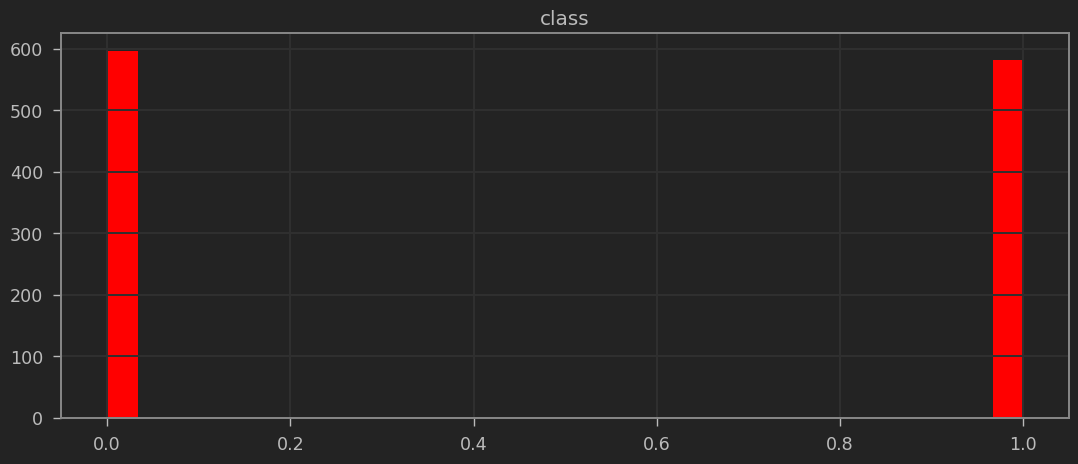

In [8]:
# Plot the histogram
df.hist(bins=30, figsize=(13,5), color='red')

In [9]:
df.sentiment.value_counts()

Negative    596
Positive    582
Name: sentiment, dtype: int64

In [10]:
# Let's get the length of the messages
df['length'] = df['tweet'].apply(len)
df.head(10)

,tweet,sentiment,highlight,class,length
0,Aw enn l ahla men hek hay li btelbesle crop to...,Negative,None,0,135
1,yu2brnee jamelo pepe happy_face_smiley tfeh sh...,Negative,None,0,89
2,Lea ktir pedophile happy_face_smiley,Negative,Bullying,0,36
3,Shu hal hmar hayda,Negative,Bullying,0,18
4,Fasharet 3a ra2btak w ra2bit m3almak w ra2bit ...,Negative,None,0,58
5,Hayda ensen marid,Negative,None,0,17
6,my uncle is lowkey aawne w ktir aabele natfo,Negative,None,0,44
7,Bassam bte7lam feyon lal syesye bel leil as a ...,Negative,Sarcasm,0,74
8,@Ritarouhana helo ktir. Eza badkoun tejo kelko...,Negative,Sarcasm,0,154
9,Hayda ma biya3ref ye2ra w yektob w bedo wazire...,Negative,None,0,85


In [11]:
df.describe()

,class,length
count,1178.000000,1178.000000
mean,0.494058,68.928693
std,0.500177,47.071377
min,0.000000,4.000000
25%,0.000000,36.000000
50%,0.000000,60.000000
75%,1.000000,90.000000
max,1.000000,620.000000


In [12]:
# Let's view the shortest tweet
df[df['length'] == 4]['tweet']

1127    Atel
Name: tweet, dtype: object

In [13]:
import re

def remove_tags_hashtags_url(tweet):
    # Remove hashtags (words starting with #)
    tweet = re.sub(r'#\w+', '', tweet)

    # Remove mentions (words starting with @)
    tweet = re.sub(r'@\w+', '', tweet)

    # Remove URLs (using a regular expression to match common URL patterns)
    tweet = re.sub(r'http[s]?://\S+', '', tweet)

    # Remove extra spaces and trim the tweet
    tweet = ' '.join(tweet.split())

    return tweet

In [14]:
tweet = df['tweet'][266]
print(tweet)
clean_tweet = remove_tags_hashtags_url(tweet)
print(clean_tweet)

Hahahhahaha albo melyen menna ðŸ¤£ https://www.facebook.com/723616625/posts/10156414568561626/
Hahahhahaha albo melyen menna ðŸ¤£


In [15]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [16]:
import nltk # Natural Language tool kit
nltk.download('stopwords')

# You have to download stopwords Package to execute this command
from nltk.corpus import stopwords
stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [17]:
stopwords.words('french')

['au',
 'aux',
 'avec',
 'ce',
 'ces',
 'dans',
 'de',
 'des',
 'du',
 'elle',
 'en',
 'et',
 'eux',
 'il',
 'ils',
 'je',
 'la',
 'le',
 'les',
 'leur',
 'lui',
 'ma',
 'mais',
 'me',
 'même',
 'mes',
 'moi',
 'mon',
 'ne',
 'nos',
 'notre',
 'nous',
 'on',
 'ou',
 'par',
 'pas',
 'pour',
 'qu',
 'que',
 'qui',
 'sa',
 'se',
 'ses',
 'son',
 'sur',
 'ta',
 'te',
 'tes',
 'toi',
 'ton',
 'tu',
 'un',
 'une',
 'vos',
 'votre',
 'vous',
 'c',
 'd',
 'j',
 'l',
 'à',
 'm',
 'n',
 's',
 't',
 'y',
 'été',
 'étée',
 'étées',
 'étés',
 'étant',
 'étante',
 'étants',
 'étantes',
 'suis',
 'es',
 'est',
 'sommes',
 'êtes',
 'sont',
 'serai',
 'seras',
 'sera',
 'serons',
 'serez',
 'seront',
 'serais',
 'serait',
 'serions',
 'seriez',
 'seraient',
 'étais',
 'était',
 'étions',
 'étiez',
 'étaient',
 'fus',
 'fut',
 'fûmes',
 'fûtes',
 'furent',
 'sois',
 'soit',
 'soyons',
 'soyez',
 'soient',
 'fusse',
 'fusses',
 'fût',
 'fussions',
 'fussiez',
 'fussent',
 'ayant',
 'ayante',
 'ayantes',


In [18]:
arabizi_stopwords = ['chu', 'chou', 'shu', 'shou', 'hal', 'fikeee', 'fike', 'eh', 'ma', '3a', '3am', '3an', '3ana', '3endon', '3m', 'aal', '3al','3ala','al', 'ana',
                 'b', 'bas', 'bass', 'bel', 'bi', 'chi', 'el', 'ele', 'enn', 'enno', 'eno', 'mch', 'mech', 'mish', '3layki', '3layon',
                 'enta', 'enteh','ente', 'eza', 'fi', 'fik', 'fina', 'fine', 'fiya', 'fiye', 'wlik', 'shi',
                 'hal', 'hayda', 'hek', 'inta', 'iza', 'kaza', 'kel', 'kente', 'kif',
                 'kint', 'kinte', 'l',  'la2na', 'lal', 'li', 'ma3', 'ma3a', 'ma3ak',
                 'ma3e', 'ma3ekk', 'ma3i', 'ma3ik', 'ma3ke', 'ma3na', 'ma3o', 'men', 'mn',
                 'n7na', 'tab', 'tayeb', 'w', 'aw', 'wlek', 'ya', 'ya3ne', 'yaane', 'yalla', 'yala', 'yalle',
                     'bl', 'hayde', 'leh', 'hay', 'lech', 'lesh']

In [19]:
def remove_punction_stop_words(tweet):
    Test_punc_removed = [char for char in tweet if char not in string.punctuation]
    Test_punc_removed_join = ''.join(Test_punc_removed)
    Test_punc_removed_join_clean_eng = [word for word in Test_punc_removed_join.split() if word.lower() not in stopwords.words('english')]
    Test_punc_removed_join_eng = ' '.join(Test_punc_removed_join_clean_eng)
    Test_punc_removed_join_clean_fr = [word for word in Test_punc_removed_join_eng.split() if word.lower() not in stopwords.words('french')]
    Test_punc_removed_join_fr = ' '.join(Test_punc_removed_join_clean_fr)
    Test_punc_removed_join_clean = [word for word in Test_punc_removed_join_fr.split() if word.lower() not in arabizi_stopwords]
    return ' '.join(Test_punc_removed_join_clean)

In [20]:
df['tweet'][0]

'Aw enn l ahla men hek hay li btelbesle crop top b noss din l sa23a w l talej w bte23ad tne2 "Msa23a" "Ya alla ktir sa23a" N2ebre lbese.'

In [21]:
clean_tweet = remove_punction_stop_words(df['tweet'][0])
clean_tweet

'ahla btelbesle crop top noss din sa23a talej bte23ad tne2 Msa23a alla ktir sa23a N2ebre lbese'

In [22]:
# function that converts tweets to lowercase
def convert_to_lowercase(tweet):
    return tweet.lower()

In [23]:
# Example usage:
text = "Shu hal HMAR hayda"
lowercase_text = convert_to_lowercase(text)

print(lowercase_text)

shu hal hmar hayda


In [24]:
def sound_effects(tweet):
    # substitute laughter sound effect
    tweet = re.sub(r'\b(hahah*)+\b', 'laughter', tweet)
    tweet = re.sub(r'\b(hihih*)+\b', 'laughter', tweet)
    tweet = re.sub(r'\b(heheh*)+\b', 'laughter', tweet)
    tweet = re.sub(r'\bwaha(ha)+\b', 'laughter', tweet)
    tweet = re.sub(r'\b(lo+l*)+\b', 'laughter', tweet)

    # substitute amazement
    tweet = re.sub(r'\b(y+a+)+y+\b', 'amazement', tweet)
    tweet = re.sub(r'\b(w+o+)+w+\b', 'amazement', tweet)
    tweet = re.sub(r'\b(w+a+)+w+\b', 'amazement', tweet)
    tweet = re.sub(r'\b(w+o+a+h+)\b', 'amazement', tweet)

    # substitute surprise
    tweet = re.sub(r'\bo+h+\b', 'surprise', tweet)
    tweet = re.sub(r'\ba+h+\b', 'surprise', tweet)
    tweet = re.sub(r'\bo+w+\b', 'surprise', tweet)


    # Remove extra spaces and trim the tweet
    tweet = ' '.join(tweet.split())

    return tweet

In [25]:
tweet = ''' hahahhahah shou mahdoum looololol
yyayyyy waawww wow oooohhhh aaahhhhh owwww woaaahhh'''
tweet = sound_effects(tweet)
print(tweet)

laughter shou mahdoum laughter amazement amazement amazement surprise surprise surprise amazement


In [26]:
# removing numbers
def remove_standalone_numbers(tweet):
    tweet =  re.sub(r'\b\d+\b', '', tweet)

    # Remove extra spaces and trim the tweet
    tweet = ' '.join(tweet.split())

    return tweet


In [27]:
# Example usage:
input_string = "Hello 123 World 456. Remove 789 and keep th1s and la2."
result = remove_standalone_numbers(input_string)
print(result)

Hello World . Remove and keep th1s and la2.


In [28]:
from cleantext import clean


def remove_emojis(tweet):
    return clean(tweet, no_emoji=True)

# Example usage:
tweet = "This is a tweet with emojis! 😊🚀🎉"
cleaned_tweet = remove_emojis(tweet)

print(cleaned_tweet)


this is a tweet with emojis!


# Data Cleaning

We will apply the functions that we created on the data we have in this order:
1. Remove user mentions, URLs, hashtags
1. Remove emojis
1. Remove standalone numbers
1. Remove punctuation and stop words
1. Convert to lowercase
1. Replace sound effects

*Note*: We have replaced all the important emojis before so in step 2. remove emojis we are removing non-significant emojis such as "eyes" and "fire" and others.

In [29]:
def tweet_cleaning(tweet):
  tweet = remove_tags_hashtags_url(tweet)
  tweet = remove_emojis(tweet)
  tweet = remove_standalone_numbers(tweet)
  tweet = remove_punction_stop_words(tweet)
  tweet = convert_to_lowercase(tweet)
  tweet = sound_effects(tweet)

  return tweet

In [30]:
tweet = df['tweet'][31]
print("Original tweet:\n" +tweet)
clean_tweet = tweet_cleaning(tweet)
print("Clean tweet:\n" + clean_tweet)

Original tweet:
Enno baddak ba3d 10 snin tenye!!!!??? Latgibo lkahraba??? Ya chabih lbani admin l3alam kello 3am bi2oul 3endkon hader belkahraba. Fachart ya harami wya 🐇🐇🐇🐇🐇
Clean tweet:
baddak ba3d snin tenye latgibo lkahraba chabih lbani admin l3alam kello bi2oul 3endkon hader belkahraba fachart harami wya


In [31]:
# Let's test the cleaning functions
df_clean = df
df_clean['tweet'] = df['tweet'].apply(tweet_cleaning)

In [32]:
df_clean

,tweet,sentiment,highlight,class,length
0,ahla btelbesle crop top noss din sa23a talej b...,Negative,None,0,135
1,yu2brnee jamelo pepe happyfacesmiley tfeh bech...,Negative,None,0,89
2,lea ktir pedophile happyfacesmiley,Negative,Bullying,0,36
3,hmar,Negative,Bullying,0,18
4,fasharet ra2btak ra2bit m3almak ra2bit khalafouk,Negative,None,0,58
...,...,...,...,...,...
1173,helo tafe2ol happyfacesmiley happyfacesmiley,Positive,None,1,65
1174,lah helo short hair,Positive,Courtesy words,1,19
1175,allah batnak laughter,Positive,Joke,1,31
1176,malla a7lam zalame man sa2ile ktir lah zake mb...,Positive,Joke,1,103


## Plot the word Cloud

In [33]:
positive = df_clean[df_clean['class']==1]
positive.head(10)

,tweet,sentiment,highlight,class,length
596,mwal3eta ween ken twitter insta happyfacesmiley,Positive,None,1,79
597,kazem saher ahla ahdam aklas 3alam,Positive,None,1,67
598,wayle helo goal,Positive,None,1,70
599,allah ayshek queen,Positive,None,1,21
600,bhbak,Positive,None,1,5
601,la2 helo ktir shab,Positive,None,1,39
602,hahaha tb howe ktr helo happyfacesmiley hahaha,Positive,None,1,71
603,kteer wjouh helwe twitter lyom allah yehmikon,Positive,None,1,51
604,wel3aani 3aylet happyfacesmiley lebanon,Positive,None,1,240
605,merci madame chta2nelik ktir happyfacesmiley,Positive,Courtesy words,1,74


In [34]:
negative = df_clean[df_clean['class']==0]
negative

,tweet,sentiment,highlight,class,length
0,ahla btelbesle crop top noss din sa23a talej b...,Negative,None,0,135
1,yu2brnee jamelo pepe happyfacesmiley tfeh bech...,Negative,None,0,89
2,lea ktir pedophile happyfacesmiley,Negative,Bullying,0,36
3,hmar,Negative,Bullying,0,18
4,fasharet ra2btak ra2bit m3almak ra2bit khalafouk,Negative,None,0,58
...,...,...,...,...,...
591,tlo3et booster mnih 3melet sakte albie,Negative,None,0,45
592,ktir sara333 wa2et ide albe,Negative,None,0,39
593,ok maybe ktir khaffe2 alile jarrabet semhoune,Negative,None,0,63
594,meto pupies frownsadangrypouting,Negative,None,0,42


In [35]:
sentences = df_clean['tweet'].tolist()
len(sentences)

1178

In [36]:
sentences_as_one_string =" ".join(sentences)

In [37]:
!pip install wordcloud

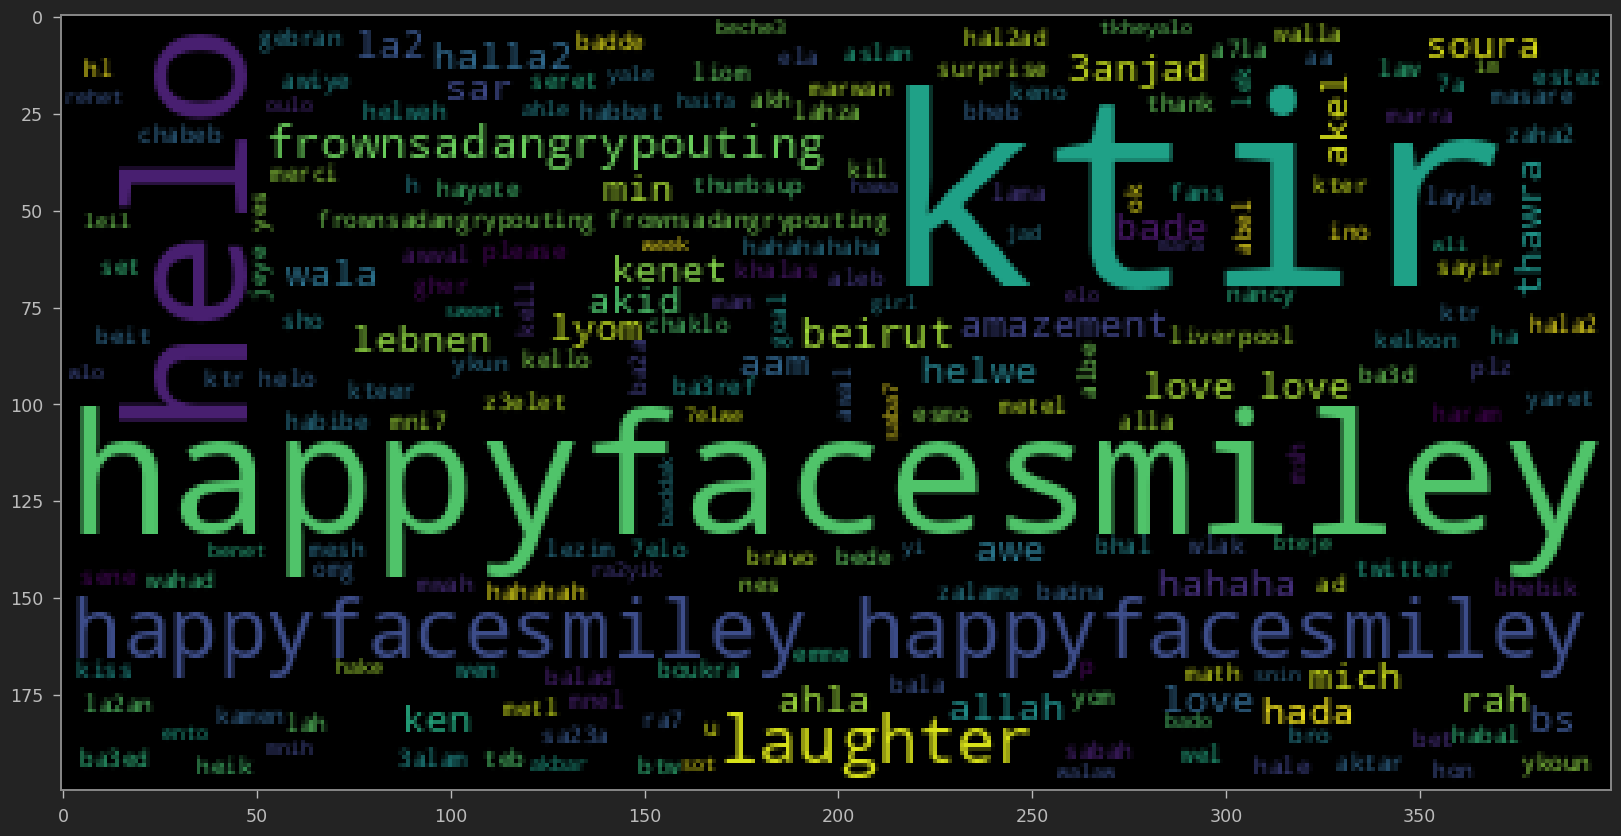

In [38]:
from wordcloud import WordCloud

plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(sentences_as_one_string))

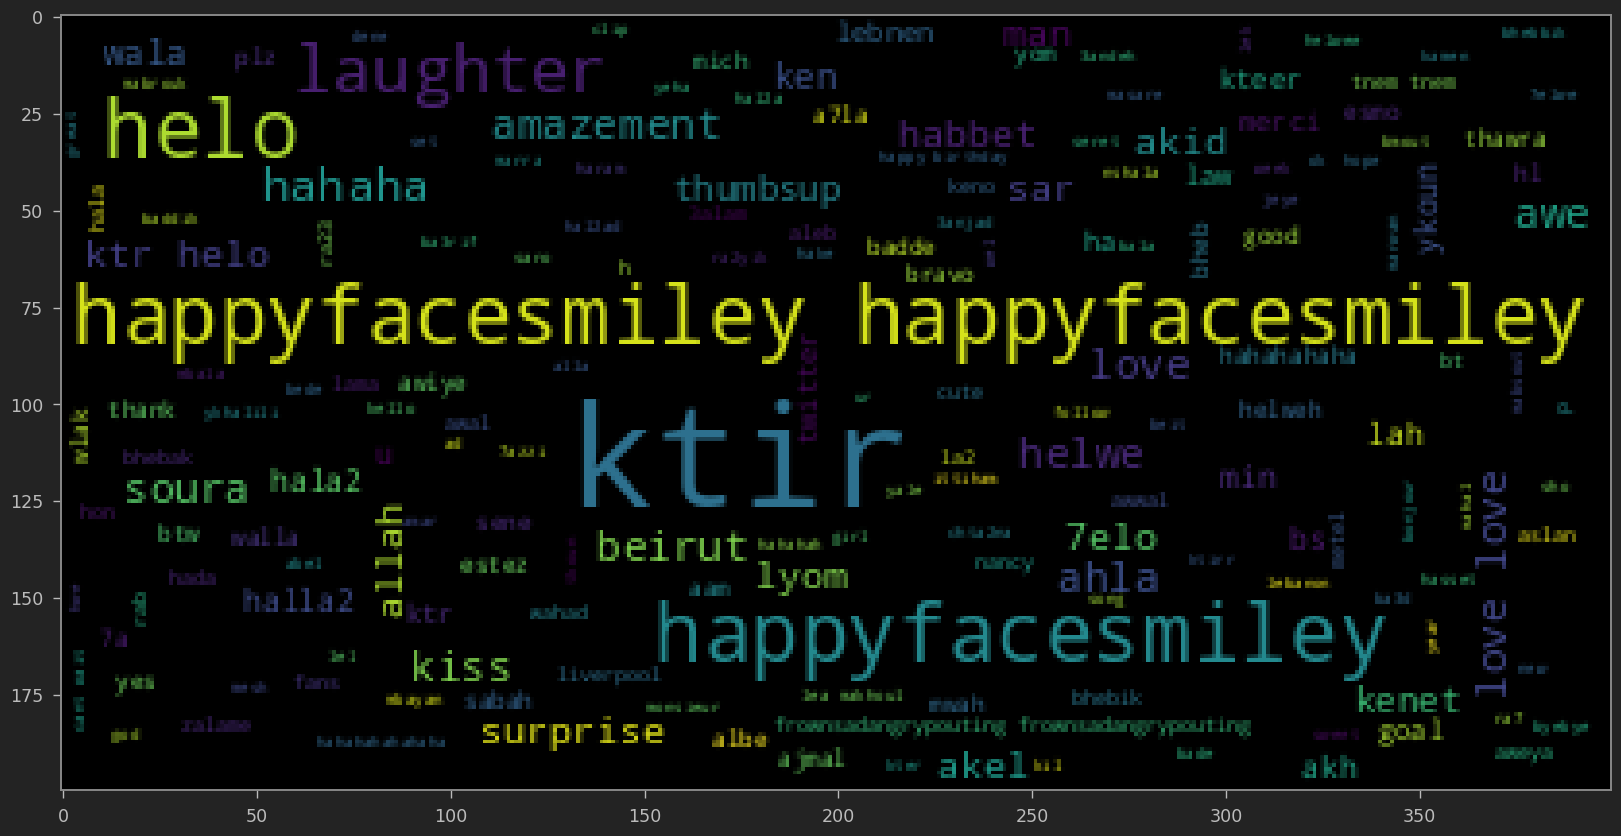

In [39]:
pos_sentences = positive['tweet'].tolist()
pos_sentences_as_one_string =" ".join(pos_sentences)
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(pos_sentences_as_one_string))

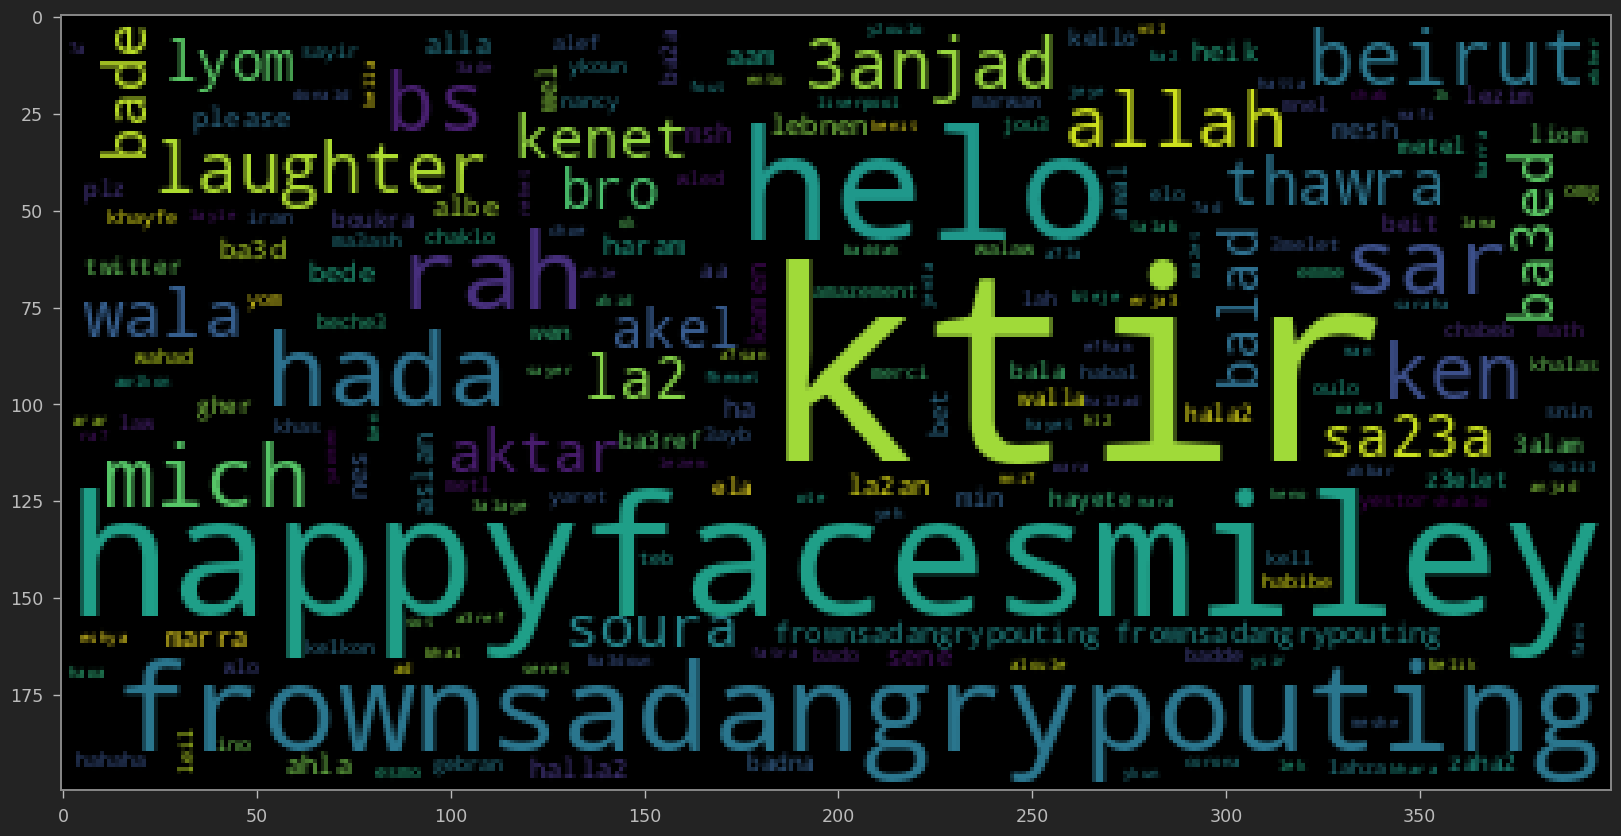

In [40]:
neg_sentences = negative['tweet'].tolist()
neg_sentences_as_one_string =" ".join(neg_sentences)
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(neg_sentences_as_one_string))

## Training/Validation Split

In [41]:
import torch
from tqdm.notebook import tqdm

In [42]:
df.head()

,tweet,sentiment,highlight,class,length
0,ahla btelbesle crop top noss din sa23a talej b...,Negative,None,0,135
1,yu2brnee jamelo pepe happyfacesmiley tfeh bech...,Negative,None,0,89
2,lea ktir pedophile happyfacesmiley,Negative,Bullying,0,36
3,hmar,Negative,Bullying,0,18
4,fasharet ra2btak ra2bit m3almak ra2bit khalafouk,Negative,None,0,58


In [43]:
# split the data into 80-20 train-test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.index.values,
                                                  df['class'].values,
                                                  test_size=.2,
                                                  random_state = 1,
                                                  stratify=df['class'].values)

In [44]:
df['data_type'] = ['not_set']*df.shape[0]

In [45]:
df.loc[X_train,'data_type'] = 'train'
df.loc[X_test,'data_type'] = 'test'

In [46]:
df.head()

,tweet,sentiment,highlight,class,length,data_type
0,ahla btelbesle crop top noss din sa23a talej b...,Negative,None,0,135,train
1,yu2brnee jamelo pepe happyfacesmiley tfeh bech...,Negative,None,0,89,train
2,lea ktir pedophile happyfacesmiley,Negative,Bullying,0,36,train
3,hmar,Negative,Bullying,0,18,train
4,fasharet ra2btak ra2bit m3almak ra2bit khalafouk,Negative,None,0,58,train


## Loading Tokenizer and Encoding Data

In [47]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [48]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                         do_lower_case = True)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [49]:
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type == 'train'].tweet.values,
    add_special_tokens=True,
    return_attention_masks= True, # when sentence starts
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt' # pytorch
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type == 'test'].tweet.values,
    add_special_tokens=True,
    return_attention_masks= True, # when sentence starts
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt' # pytorch
)


encoded_data_train['input_ids']

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Keyword arguments {'return_attention_masks': True} not recognized.
Keyword arguments {'return_atten

tensor([[  101, 18347,  2050,  ...,     0,     0,     0],
        [  101,  9805,  2475,  ...,     0,     0,     0],
        [  101, 12203,  1047,  ...,     0,     0,     0],
        ...,
        [  101, 16455,  7151,  ...,     0,     0,     0],
        [  101,  6670,  2050,  ...,     0,     0,     0],
        [  101, 12316,  2213,  ...,     0,     0,     0]])

In [50]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train']['class'].values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='test']['class'].values)

In [51]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [52]:
len(dataset_train)

942

In [53]:
len(dataset_val)

236

## Setting up BERT Pretrained Model

In [54]:
from transformers import BertForSequenceClassification

In [55]:
possible_labels = df.sentiment.unique()

In [56]:
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [57]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                      num_labels=len(label_dict),
                                      output_attentions=False,
                                      output_hidden_states = False
                                     )

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Creating Data Loaders

In [58]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [59]:
batch_size = 4 # 32

dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size = batch_size
)

dataloader_val = DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size = 32
)

## Setting Up Optimizer and Scheduler

In [60]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [61]:
optimizer = AdamW(
    model.parameters(),
    lr=1e-5, # 2e-5 > 5e-5
    eps=1e-8
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [62]:
epochs = 10

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps = len(dataloader_train)*epochs
)

## Defining Performance Metrics

In [63]:
from sklearn.metrics import f1_score

In [64]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [65]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v:k for k, v in label_dict.items()}


    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat == label]
        y_true = labels_flat[labels_flat == label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/ {len(y_true)}\n')
    return

## Creating our Training Loop

In [66]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val) # if you're using gpu

In [67]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cpu


In [68]:
def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in tqdm(dataloader_val):

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals


In [69]:
for epoch in tqdm(range(1, epochs+1)):
    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train,
                        desc="Epoch {:1d}".format(epoch),
                        leave=False,
                       disable =False)

    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            "attention_mask": batch[1],
            'labels': batch[2]
        }

        outputs = model(**inputs)


        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})


    torch.save(model.state_dict(), f'/content/drive/MyDrive/NLP/Models/BERT_ft_epoch{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 score(weighted): {val_f1}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/236 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.6326351934191534


  0%|          | 0/8 [00:00<?, ?it/s]

Validation loss: 0.539229940623045
F1 score(weighted): 0.74145578031224


Epoch 2:   0%|          | 0/236 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.5384358394322759


  0%|          | 0/8 [00:00<?, ?it/s]

Validation loss: 0.5799907483160496
F1 score(weighted): 0.7452135241740218


Epoch 3:   0%|          | 0/236 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.4976741576614648


  0%|          | 0/8 [00:00<?, ?it/s]

Validation loss: 0.6675999090075493
F1 score(weighted): 0.7614791987673343


Epoch 4:   0%|          | 0/236 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.4638494804690955


  0%|          | 0/8 [00:00<?, ?it/s]

Validation loss: 0.9215991050004959
F1 score(weighted): 0.7485426029202087


Epoch 5:   0%|          | 0/236 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.41975670957432715


  0%|          | 0/8 [00:00<?, ?it/s]

Validation loss: 1.2032692357897758
F1 score(weighted): 0.7046186440677966


Epoch 6:   0%|          | 0/236 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.2782507218791456


  0%|          | 0/8 [00:00<?, ?it/s]

Validation loss: 1.2054118812084198
F1 score(weighted): 0.7408603429477648


Epoch 7:   0%|          | 0/236 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.24731807670777


  0%|          | 0/8 [00:00<?, ?it/s]

Validation loss: 1.2771546989679337
F1 score(weighted): 0.7444419986792867


Epoch 8:   0%|          | 0/236 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.2051051904396075


  0%|          | 0/8 [00:00<?, ?it/s]

Validation loss: 1.270088989927899
F1 score(weighted): 0.7403372169730464


Epoch 9:   0%|          | 0/236 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.1862484548527992


  0%|          | 0/8 [00:00<?, ?it/s]

Validation loss: 1.3733937963843346
F1 score(weighted): 0.749842826606312


Epoch 10:   0%|          | 0/236 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.13613725600022256


  0%|          | 0/8 [00:00<?, ?it/s]

Validation loss: 1.3362386226654053
F1 score(weighted): 0.7453971132332081


In [69]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [70]:
model.to(device)
pass

In [71]:
model.load_state_dict(torch.load('/content/drive/MyDrive/NLP/Models/BERT_ft_epoch10.model',
                                map_location = torch.device('cpu')))

<All keys matched successfully>

In [72]:
 _, predictions, true_vals = evaluate(dataloader_val)

  0%|          | 0/8 [00:00<?, ?it/s]

In [73]:
accuracy_per_class(predictions, true_vals)

Class: Negative
Accuracy: 84/ 119

Class: Positive
Accuracy: 92/ 117

